# Evaluation the Sea Ice Concentration in the Base Experiment
Evaluate the spatial patterns and biases of simulated sea ice concentration in the base, control experiment to determine the years to run additional perturbation experiments in that test the sensitivity of the Bering Strait transport response to sea ice concentration in the vicinity of the wind perturbation.

1. Plot mean `tauy` perturbation from the 2008 run with Feb `siconc` contoured over that. Add red box to demonstrate bounds of Bering Sea region for calculating the integrated surface perturbations.
2. Plot the monthly mean sea ice concentration in the Bering Sea region. Add the red dot on each Feb there is a perturbation experiment
2. Calculate the integrated perturbation surface stress (`taux`, `tauy` from the ocean model are really a surface stress, not just wind stress, so take sea ice into account) and plot against integrated sea ice concentration over the same area.


**Re-do calculation for confirimation with fixed base experiment pp**

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import subprocess

In [2]:
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import numpy as np

## Read in model data

In [3]:
def open_2D_data(exp):
    # file list
    base = '/archive/Marion.Alberty/FMS2021.02_mom6_devgfdl_20221223/OM4p25_JRA55do1.4_0netfw_cde.02_BWP_'
    pp = '/gfdl.ncrc4-intel18-prod/pp/'
    o_daily = 'ocean_daily/ts/daily/*yr/'
    i_daily = 'ice_daily/ts/daily/*yr/'
    flist = (
        glob(f'{base}{exp}{pp}{o_daily}*.taux.nc') + # taux
        glob(f'{base}{exp}{pp}{o_daily}*.tauy.nc') + # tauy
        glob(f'{base}{exp}{pp}{o_daily}../../../ocean_daily.static.nc') + # ocean static
        glob(f'{base}{exp}{pp}{i_daily}*.siconc.nc') # siconc
    )
    
    # dmget files
    _ = subprocess.run(["dmget"]+flist, check=True)
    
    v2drop = ['average_DT', 'average_T1', 'average_T2','time_bnds']
    # open model data
    DS = xr.open_mfdataset(flist,use_cftime=True,combine='by_coords',engine='netcdf4',
                           drop_variables=v2drop)
        
    # drop ice coords and swap ice dims to ocean dims
    DS = DS.drop(('xT','yT','xTe','yTe')).rename({'xT':'xh','yT':'yh'})
    
    # assign geolat and geolon from ocean static
    DS = DS.set_coords(['geolon','geolat','geolon_c','geolat_c',
                        'geolon_u','geolat_u','geolon_v','geolat_v'])
    return DS

In [4]:
ctrl = open_2D_data('ctrl')

In [5]:
p98 = open_2D_data('68.193_Lx300_Ly500_tau28_v10_1998')

In [6]:
p01 = open_2D_data('68.193_Lx300_Ly500_tau28_v10_2001')

In [7]:
p08 = open_2D_data('68.193_Lx300_Ly500_tau28_v10')

In [8]:
p12 = open_2D_data('68.193_Lx300_Ly500_tau28_v10_2012')

In [9]:
p16 = open_2D_data('68.193_Lx300_Ly500_tau28_v10_2016')

## Plot of mean map
Plot mean `tauy` perturbation from the 2008 run with Feb `siconc` contoured over that. Add red box to demonstrate bounds of Bering Sea region for calculating the integrated surface perturbations

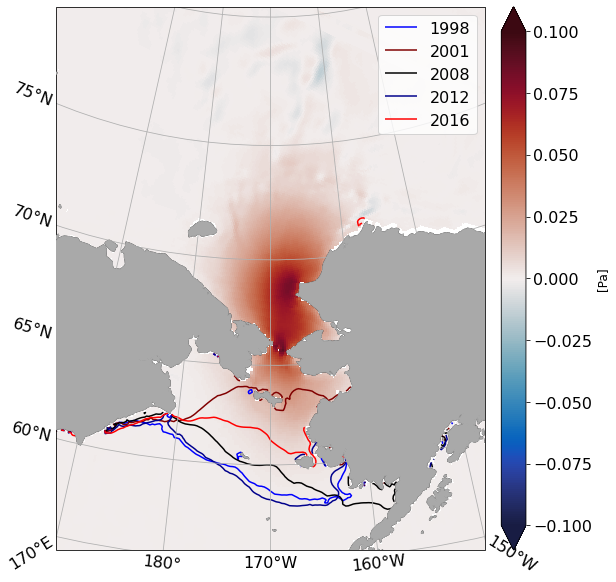

In [41]:
fig, ax = plt.subplots(figsize=(15,10),subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-170)})

# Specify data projection
crs = ccrs.PlateCarree()

# Pull variabile for plotting
x = p08['geolon_v']
y = p08['geolat_v']
z = (p08['tauy'] - ctrl['tauy']).sel(time=slice('2008-04-01','2008-12-31')).mean('time')
# plot tauy
im = ax.pcolormesh(x,y,z,transform=crs,cmap='cmo.balance',
                   vmin=-0.1,vmax=0.1,rasterized=True)
# add colorbar
cbar = plt.colorbar(im,ax=ax,fraction=0.03,pad=0.02,extend='both')
# colorbar label with units
units = p08['tauy'].units
cbar.set_label(f'[{units}]',fontsize=12)

# get Feb sea ice concentration
c98 = ax.contour(ctrl['geolon'],ctrl['geolat'],
                 ctrl['siconc'].sel(time=slice('1998-02-01','1998-03-01')).mean('time'),
                 levels=[0.9],transform=crs,colors='blue')
c01 = ax.contour(ctrl['geolon'],ctrl['geolat'],
                 ctrl['siconc'].sel(time=slice('2001-02-01','2001-03-01')).mean('time'),
                 levels=[0.9],transform=crs,colors='maroon')
c08 = ax.contour(ctrl['geolon'],ctrl['geolat'],
                 ctrl['siconc'].sel(time=slice('2008-02-01','2008-03-01')).mean('time'),
                 levels=[0.9],transform=crs,colors='black')
c12 = ax.contour(ctrl['geolon'],ctrl['geolat'],
                 ctrl['siconc'].sel(time=slice('2012-02-01','2012-03-01')).mean('time'),
                 levels=[0.9],transform=crs,colors='darkblue')
c16 = ax.contour(ctrl['geolon'],ctrl['geolat'],
                 ctrl['siconc'].sel(time=slice('2016-02-01','2016-03-01')).mean('time'),
                 levels=[0.9],transform=crs,colors='red')

h0,_ = c98.legend_elements()
h1,_ = c01.legend_elements()
h2,_ = c08.legend_elements()
h3,_ = c12.legend_elements()
h4,_ = c16.legend_elements()
ax.legend([h0[0], h1[0], h2[0], h3[0], h4[0]],
          ['1998', '2001', '2008', '2012', '2016'])


 # Zoom in around Bering Strait
ax.set_extent([-190,-150,55,80],crs=crs)

# Add a land mask to your plot, as well as grid lines and coastlines
ax.add_feature(cfeature.LAND,zorder=9,facecolor='darkgray')
gl = ax.gridlines(draw_labels=True,dms=True,x_inline=False,y_inline=False,
                  crs=crs,xlocs=[170,-180,-170,-160,-150,])
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines()

plt.show()

## Sea ice concentration time series
Plot the monthly mean sea ice concentration in the Bering Sea region. Add the monthly mean time series of each perturbation experiment on top in red or blue.

In [10]:
cond = ((p08['geolat']>=55)&(p08['geolat']<=75)
        &(p08['geolon']>=-180)&(p08['geolon']<=-160)
        &(p08['wet']==1))

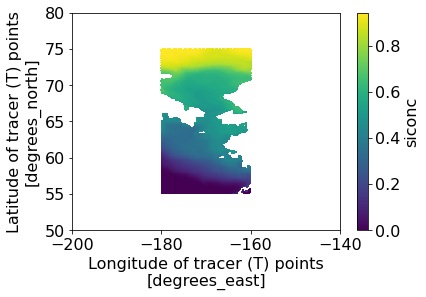

In [43]:
p08['siconc'].where(cond,drop=True).mean('time').plot(x='geolon',y='geolat')
plt.ylim(50,80)
plt.xlim(-200,-140)
plt.show()

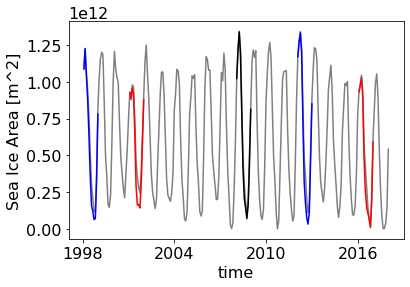

In [32]:
(ctrl['siconc'].resample(time='1M').mean()*ctrl['areacello']).where(cond).sum(['xh','yh']).plot(color='grey')
(p98['siconc'].resample(time='1M').mean()*p98['areacello']).where(cond).sum(['xh','yh']).plot(color='blue')
(p01['siconc'].resample(time='1M').mean()*p01['areacello']).where(cond).sum(['xh','yh']).plot(color='red')
(p08['siconc'].resample(time='1M').mean()*p08['areacello']).where(cond).sum(['xh','yh']).plot(color='black')
(p12['siconc'].resample(time='1M').mean()*p12['areacello']).where(cond).sum(['xh','yh']).plot(color='blue')
(p16['siconc'].resample(time='1M').mean()*p16['areacello']).where(cond).sum(['xh','yh']).plot(color='red')
plt.ylabel('Sea Ice Area [m^2]')
plt.show()

## Load Bering Strait Transports

In [14]:
def open_BS_data(exp):
    # file list
    base = '/archive/Marion.Alberty/FMS2021.02_mom6_devgfdl_20221223/OM4p25_JRA55do1.4_0netfw_cde.02_BWP_'
    pp = '/gfdl.ncrc4-intel18-prod/pp/ocean_Bering_Strait/ts/daily/*yr/'
    flist = (
        glob(f'{base}{exp}{pp}*vmo.nc') +
        # glob(f'{base}{exp}{pp}*vo.nc') +
        # glob(f'{base}{exp}{pp}*vo_g.nc') +
        # glob(f'{base}{exp}{pp}*vo_bt.nc') +
        glob(f'{base}{exp}{pp}*volcello.nc')
    )
    
    # dmget files
    _ = subprocess.run(["dmget"]+flist, check=True)
    
    v2drop = ['average_DT', 'average_T1', 'average_T2','time_bnds']
    # open and clean up model data
    DS = xr.open_mfdataset(flist,use_cftime=True,combine='by_coords',engine='netcdf4',
                           drop_variables=v2drop)
    # Clean up coordinate names
    crds2chng = [match for match in list(DS.coords) if "_sub01" in match]
    for i in crds2chng:
        DS = DS.rename_dims({i:i[:2]}).rename({i:i[:2]})
        
    # dmget ocean static
    f_OS = f'{base}{exp}{pp}../../../ocean_Bering_Strait.static.nc'
    _ = subprocess.run(["dmget"]+[f_OS],check=True)
        
    # open the static file
    OS = xr.open_dataset(f_OS,engine='netcdf4')
    
    # assign geolat and geolon from ocean static
    DS = DS.assign_coords({'geolon_v':OS['geolon_v'].sel(xh=DS.xh,yq=DS.yq),
                           'geolat_v':OS['geolat_v'].sel(xh=DS.xh,yq=DS.yq)})
    
    # merge in static data
    DS = xr.merge([DS,
                   OS['areacello'].sel(xh=DS.xh,yh=DS.yh),
                   OS['areacello_cv'].sel(xh=DS.xh,yq=DS.yq),
                   OS['dxCv'].sel(xh=DS.xh,yq=DS.yq),
                   OS['dyCv'].sel(xh=DS.xh,yq=DS.yq)]).squeeze()
    
    # # calc dz_v
    # DS['dzCv'] = DS['volcello']/DS['areacello']
    
    # reference density
    rho_0 = 1035
    # total transport
    DS['T_vmo'] = DS['vmo'].sum(['xh','z_l'])/rho_0*(1e-6)
    # # calc transports for each vo term
    # terms = ['vo', 'vo_g', 'vo_bt']
    # for term in terms:
    #     DS['T_' + term] = (1e-6 * DS[term] * DS.dzCv * DS.dxCv).sum(['xh','z_l'])
    
    return DS

In [15]:
Tctrl = open_BS_data('ctrl')

In [16]:
Tp98 = open_BS_data('68.193_Lx300_Ly500_tau28_v10_1998')

In [17]:
Tp01 = open_BS_data('68.193_Lx300_Ly500_tau28_v10_2001')

In [18]:
Tp08 = open_BS_data('68.193_Lx300_Ly500_tau28_v10')

In [19]:
Tp12 = open_BS_data('68.193_Lx300_Ly500_tau28_v10_2012')

In [20]:
Tp16 = open_BS_data('68.193_Lx300_Ly500_tau28_v10_2016')

## Integrate wind stress and sea ice area

In [30]:
def merge_2_TS(BS,twoD):
    TS = xr.Dataset()
    # get BS transport
    TS['T'] = BS['T_vmo'].resample(time='1M').mean()
    
    cond = ((twoD['geolat']>=55)&(twoD['geolat']<=75)
            &(twoD['geolon']>=-180)&(twoD['geolon']<=-160)
            &(twoD['wet']==1))
    
    condy = ((twoD['geolat_v']>=55)&(twoD['geolat_v']<=75)
             &(twoD['geolon_v']>=-180)&(twoD['geolon_v']<=-160)
             &(twoD['wet_v']==1))
    
    condx = ((twoD['geolat_u']>=55)&(twoD['geolat_u']<=75)
             &(twoD['geolon_u']>=-180)&(twoD['geolon_u']<=-160)
             &(twoD['wet_u']==1))
    
    # integrated sea ice area
    TS['siarea'] = (twoD['siconc']*twoD['areacello']).where(cond,drop=True).sum(['xh','yh']).resample(time='1M').mean()
    # integrated surface stress
    TS['Fy'] = (twoD['tauy'] * twoD['areacello_cv']).where(condy,drop=True).sum(['xh','yq']).resample(time='1M').mean()
    TS['Fx'] = (twoD['taux'] * twoD['areacello_cu']).where(condx,drop=True).sum(['xq','yh']).resample(time='1M').mean()
    return TS

In [31]:
TSctrl = merge_2_TS(Tctrl,ctrl)

In [32]:
TSp98 = merge_2_TS(Tp98,p98)

In [33]:
TSp01 = merge_2_TS(Tp01,p01)

In [34]:
TSp08 = merge_2_TS(Tp08,p08)

In [35]:
TSp12 = merge_2_TS(Tp12,p12)

In [36]:
TSp16 = merge_2_TS(Tp16,p16)

## Scatter plots of transport vs (SIarea,Fy,Fx)

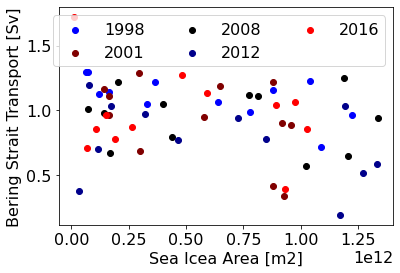

In [40]:
plt.scatter(TSp98['siarea'],TSp98['T'],c='blue',label='1998')
plt.scatter(TSp01['siarea'],TSp01['T'],c='maroon',label='2001')
plt.scatter(TSp08['siarea'],TSp08['T'],c='black',label='2008')
plt.scatter(TSp12['siarea'],TSp12['T'],c='darkblue',label='2012')
plt.scatter(TSp16['siarea'],TSp16['T'],c='red',label='2016')
plt.legend(ncol=3)
plt.ylabel('Bering Strait Transport [Sv]')
plt.xlabel('Sea Icea Area [m2]')
plt.show()

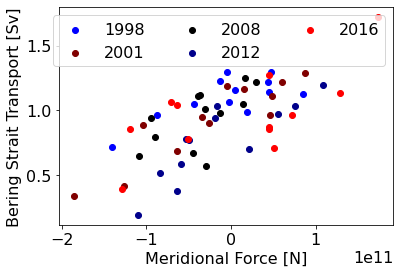

In [44]:
plt.scatter(TSp98['Fy'],TSp98['T'],c='blue',label='1998')
plt.scatter(TSp01['Fy'],TSp01['T'],c='maroon',label='2001')
plt.scatter(TSp08['Fy'],TSp08['T'],c='black',label='2008')
plt.scatter(TSp12['Fy'],TSp12['T'],c='darkblue',label='2012')
plt.scatter(TSp16['Fy'],TSp16['T'],c='red',label='2016')
plt.legend(ncol=3)
plt.ylabel('Bering Strait Transport [Sv]')
plt.xlabel('Meridional Force [N]')
plt.show()

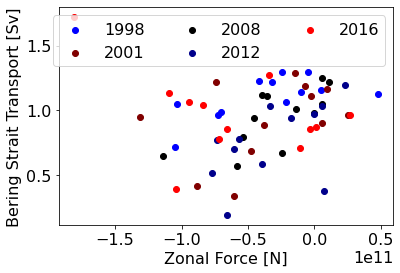

In [41]:
plt.scatter(TSp98['Fx'],TSp98['T'],c='blue',label='1998')
plt.scatter(TSp01['Fx'],TSp01['T'],c='maroon',label='2001')
plt.scatter(TSp08['Fx'],TSp08['T'],c='black',label='2008')
plt.scatter(TSp12['Fx'],TSp12['T'],c='darkblue',label='2012')
plt.scatter(TSp16['Fx'],TSp16['T'],c='red',label='2016')
plt.legend(ncol=3)
plt.ylabel('Bering Strait Transport [Sv]')
plt.xlabel('Zonal Force [N]')
plt.show()